Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [4]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [5]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

首先，引入显示图片需要的库Image和display，在目录里面随便照一张显示，熟悉display和Image的使用方法。

In [6]:
from IPython.display import display, Image
display(Image(filename="notMNIST_small/A/Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png"))

然后随机找几张图片显示出来，作为开始机器学习的第一步：看数据，包括训练集和测试集。

In [7]:
import random
def disp_samples(data_folders, sample_size):
  for folder in data_folders:
    print(folder)
    image_files = os.listdir(folder)
    image_sample = random.sample(image_files, sample_size)
    for image in image_sample:
      image_file = os.path.join(folder, image)
      i = Image(filename=image_file)
      display(i)

In [8]:
disp_samples(train_folders, 1)

notMNIST_large/A


notMNIST_large/B


notMNIST_large/C


notMNIST_large/D


notMNIST_large/E


notMNIST_large/F


notMNIST_large/G


notMNIST_large/H


notMNIST_large/I


notMNIST_large/J


In [9]:
disp_samples(test_folders, 1)

notMNIST_small/A


notMNIST_small/B


notMNIST_small/C


notMNIST_small/D


notMNIST_small/E


notMNIST_small/F


notMNIST_small/G


notMNIST_small/H


notMNIST_small/I


notMNIST_small/J


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

下面代码读取图片（28 * 28）为numpy数组，然后用python的序列化机制pickle存到文件中，每种字母一个文件。

In [10]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)
print(train_datasets)
print(test_datasets)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

为了证明我们上一步做的序列化没有把数据搞坏， 我们验证一下把pickle里面的数据显示成图像。

In [11]:
def disp_8_img(imgs, titles = None):
  """Display subplot with 8 images or less"""
  for i, img in enumerate(imgs):
    plt.subplot(2, 4, i+1)
    # plt.title(titles[i])
    plt.axis('off')
    plt.imshow(img)

def disp_sample_pickles(data_folders):
  folder = random.sample(data_folders, 1)
  pickle_filename = ''.join(folder) + '.pickle'
  try:
    with open(pickle_filename, 'rb') as f:
      dataset = pickle.load(f)
  except Exception as e:
    print('Unable to read data from', pickle_filename, ':', e)
    return
  # display
  plt.suptitle(''.join(folder)[-1])
  disp_8_img(random.sample(list(dataset), 8))

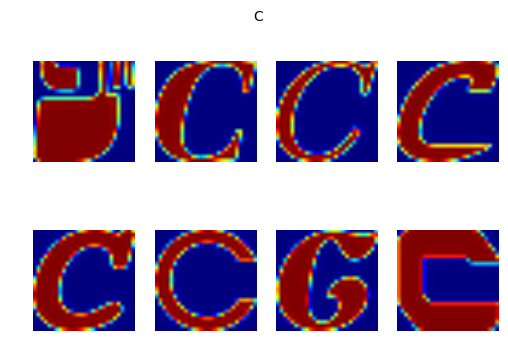

In [12]:
disp_sample_pickles(train_folders)

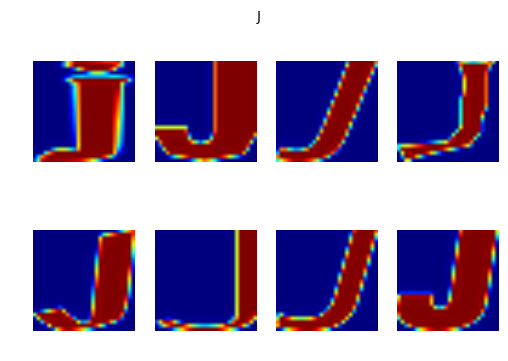

In [13]:
disp_sample_pickles(test_folders)

(52909, 28, 28) (28, 28)


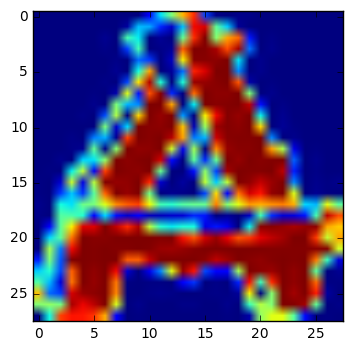

In [14]:
pickle_file = train_datasets[0]
with open(pickle_file, 'rb') as f:
    letter_set = pickle.load(f)  # 反序列化
    sample_idx = np.random.randint(len(letter_set))  # 随机选一张图片
    print(letter_set.shape, letter_set[sample_idx].shape)
    sample_image = letter_set[sample_idx, :, :]  # 提取数据
    plt.figure()
    plt.imshow(sample_image)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

检查看看数据是否“平衡”，即每个类别数据量是否大体一致。

In [15]:
def num_of_class(folders):
    for folder in folders:
        pickle_file = folder + '.pickle'
        try:
            with open(pickle_file, 'rb') as f:
                dataset = pickle.load(f)
        except Exception as e:
            print('read data from ', pickle_file, ' failed. error: ', e)
            return
        print('number of images in ', folder, ' = ', len(dataset))

num_of_class(train_folders)
num_of_class(test_folders)

number of images in  notMNIST_large/A  =  52909
number of images in  notMNIST_large/B  =  52911
number of images in  notMNIST_large/C  =  52912
number of images in  notMNIST_large/D  =  52911
number of images in  notMNIST_large/E  =  52912
number of images in  notMNIST_large/F  =  52912
number of images in  notMNIST_large/G  =  52912
number of images in  notMNIST_large/H  =  52912
number of images in  notMNIST_large/I  =  52912
number of images in  notMNIST_large/J  =  52911
number of images in  notMNIST_small/A  =  1872
number of images in  notMNIST_small/B  =  1873
number of images in  notMNIST_small/C  =  1873
number of images in  notMNIST_small/D  =  1873
number of images in  notMNIST_small/E  =  1873
number of images in  notMNIST_small/F  =  1872
number of images in  notMNIST_small/G  =  1872
number of images in  notMNIST_small/H  =  1872
number of images in  notMNIST_small/I  =  1872
number of images in  notMNIST_small/J  =  1872


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

把A-J的pickle文件合并起来，随机抽取一些example作为训练集、验证集和测试集。

In [42]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

打乱训练集、验证集和测试集的数据， 保证SGD的有效性。

In [43]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

再次验证随机化洗牌没有把数据搞乱（每次修改都验证数据有没有被搞坏！每次修改都验证数据有没有被搞坏！每次修改都验证数据有没有被搞坏！）。随机挑选数据显示出图片， 看是否跟label一致。

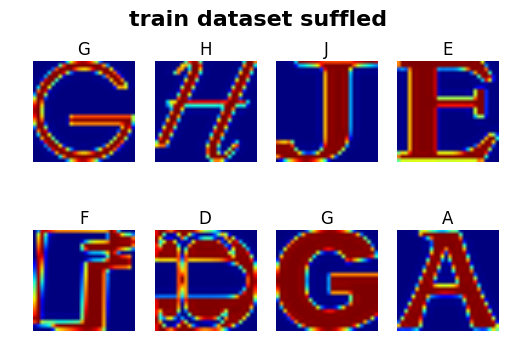

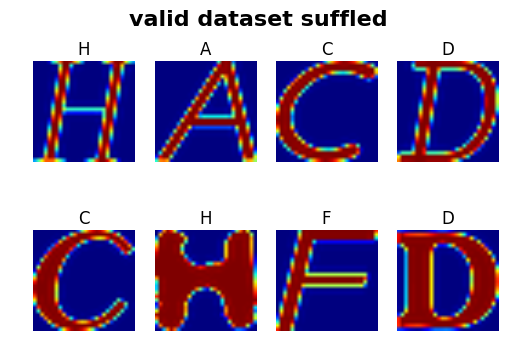

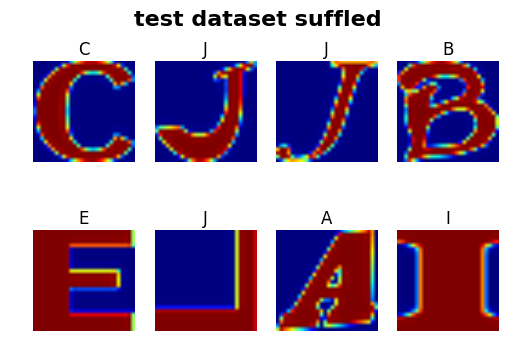

In [44]:
def plot_sample_dataset(dataset, labels, title):
    plt.suptitle(title, fontsize=16, fontweight='bold')
    items = random.sample(range(len(labels)), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i + 1)
        plt.axis('off')
        plt.title(chr(ord('A') + labels[item])) # label里面存的是数字了，0 -> A, 1 -> B, 2 -> C, ..., 9 -> J
        plt.imshow(dataset[item])
    plt.show()
 
plot_sample_dataset(train_dataset, train_labels, 'train dataset suffled')
plot_sample_dataset(valid_dataset, valid_labels, 'valid dataset suffled')
plot_sample_dataset(test_dataset, test_labels, 'test dataset suffled')

Finally, let's save the data for later reuse:

In [45]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [46]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800503


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

如果test集里的数据跟train集数据有重叠，对最终结果是有影响的。极限情况下，test集就是train的一个子集，那overfitting问题就会很严重！所以开始训练之前， 看一下有多少数据重叠可以对overfitting是否严重有一个准确的预估。首先我们看看有多少是重叠的，即图片内容完全一样！

In [47]:
def get_overlap(dataset1, dataset2):
    overlap = {}
    for i, img1 in enumerate(dataset1):
        for j, img2 in enumerate(dataset2):
            if np.array_equal(img1, img2):
                if not i in overlap.keys():
                    overlap[i] = []
                overlap[i].append(j)
    return overlap

In [48]:
%time overlap = get_overlap(test_dataset[:200], train_dataset)

CPU times: user 3min 7s, sys: 486 ms, total: 3min 8s
Wall time: 3min 9s


In [49]:
print('number of overlaps: ', len(overlap.keys()))

number of overlaps:  26


In [56]:
def display_overlap(overlap, source_dataset, target_dataset):
#     for key in overlap:
    key = random.choice(list(overlap.keys()))
    imgs = np.concatenate(([source_dataset[key]], target_dataset[overlap[key][0:7]]))
    plt.figure()
    plt.suptitle(key)
    for i, img in enumerate(imgs):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.imshow(img)

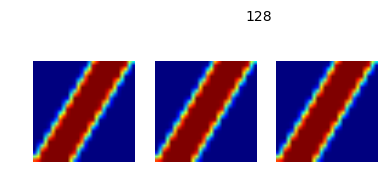

In [58]:
display_overlap(overlap, test_dataset[:200], train_dataset)

速度比较慢，我们来优化一下，主要从下面几个方面：
1. 找到一个duplicate的就停止
2. 用hash
3. 用numpy自带的函数

CPU times: user 2min 55s, sys: 517 ms, total: 2min 56s
Wall time: 2min 57s
number of overlaps:  26


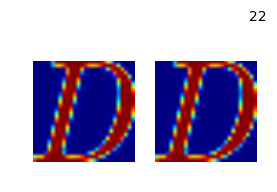

In [59]:
def get_overlap_stop(dataset1, dataset2):
    overlap = {}
    for i, img1 in enumerate(dataset1):
        for j, img2 in enumerate(dataset2):
            if np.array_equal(img1, img2):
                if not i in overlap.keys():
                    overlap[i] = [j]
                    break
    return overlap
%time overlap = get_overlap_stop(test_dataset[:200], train_dataset)
print('number of overlaps: ', len(overlap.keys()))
display_overlap(overlap, test_dataset[:200], train_dataset)

基本没什么变化， 我们来试试hash。

CPU times: user 4.04 s, sys: 11.9 ms, total: 4.05 s
Wall time: 4.08 s
number of overlaps:  26


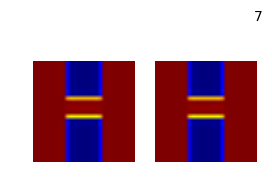

In [60]:
import hashlib

def get_overlap(dataset1, dataset2):
    dataset1_hash = [hashlib.md5(img).hexdigest() for img in dataset1]
    dataset2_hash = [hashlib.md5(img).hexdigest() for img in dataset2]
    overlap = {}
    for i, hash1 in enumerate(dataset1_hash):
        for j, hash2 in enumerate(dataset2_hash):
            if hash1 == hash2:
                if not i in overlap.keys():
                    overlap[i] = []
                overlap[i].append(j)
    return overlap
%time overlap = get_overlap(test_dataset[:200], train_dataset)
print('number of overlaps: ', len(overlap.keys()))
display_overlap(overlap, test_dataset[:200], train_dataset)

In [62]:
%time overlap = get_overlap(test_dataset, train_dataset)
print('number of overlaps: ', len(overlap.keys()))

CPU times: user 2min 21s, sys: 452 ms, total: 2min 21s
Wall time: 2min 22s
number of overlaps:  1283


CPU times: user 1.76 s, sys: 26.9 ms, total: 1.79 s
Wall time: 1.81 s
number of overlaps:  26


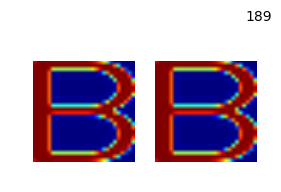

In [63]:
import hashlib

def get_overlap(dataset1, dataset2):
    dataset1_hash = np.array([hashlib.md5(img).hexdigest() for img in dataset1])
    dataset2_hash = np.array([hashlib.md5(img).hexdigest() for img in dataset2])
    overlap = {}
    for i, hash1 in enumerate(dataset1_hash):
        duplicates = np.where(dataset2_hash == hash1)
        if len(duplicates[0]):
            overlap[i] = duplicates[0]
    return overlap
%time overlap = get_overlap(test_dataset[:200], train_dataset)
print('number of overlaps: ', len(overlap.keys()))
display_overlap(overlap, test_dataset[:200], train_dataset)

In [64]:
%time overlap = get_overlap(test_dataset, train_dataset)
print('number of overlaps: ', len(overlap.keys()))
# display_overlap(overlap, test_dataset[:200], train_dataset)

CPU times: user 23.1 s, sys: 82 ms, total: 23.1 s
Wall time: 23.2 s
number of overlaps:  1283


我们已经显示了duplicate的图片， 现在来找一下near duplicate的。那么怎么定义near呢？一种简单的方法就是两张图片按像素点挨个相减，看差值的绝对值之和，也就是所谓的曼哈顿距离。想起以前毕业论文做视频镜头切分，首先也是按像素点做image diff， 如果算下来差异很小的话， 说明基本是同一个镜头里的同一个画面，可以快速略过。如果我没讲清楚的， 大家想想“大家来找茬”这个游戏就懂了。

In [117]:
DIS_THRESHOLD = 10

def get_overlap_near(dataset1, dataset2):
    overlap = {}
    for i, img1 in enumerate(dataset1):
        for j, img2 in enumerate(dataset2):
            diff = img1 - img2
            distance = np.sum(np.abs(diff))
            if distance <= DIS_THRESHOLD:
                if not i in overlap.keys():
                    overlap[i] = []
                overlap[i].append(j)
    return overlap

In [118]:
%time overlap = get_overlap_near(test_dataset[:200], train_dataset)

CPU times: user 34.3 s, sys: 241 ms, total: 34.6 s
Wall time: 34.8 s


number of overlaps:  7


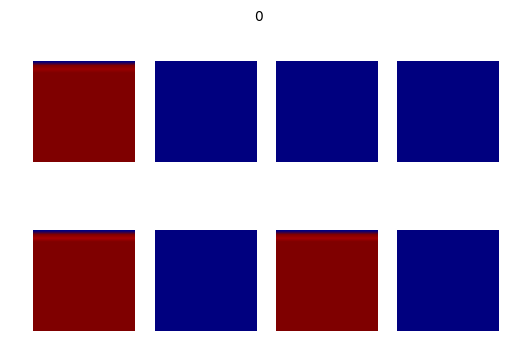

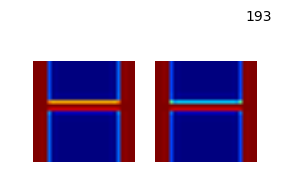

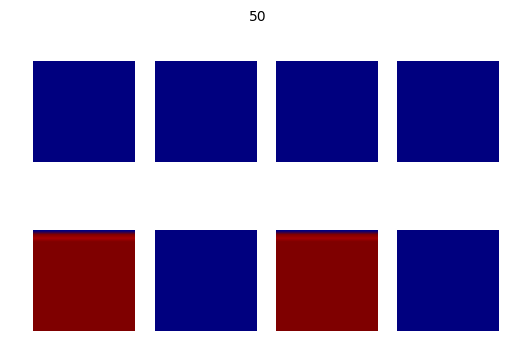

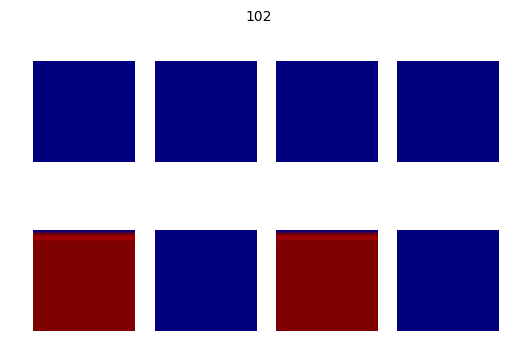

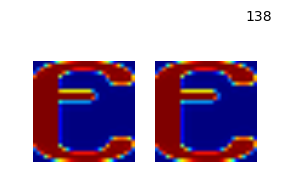

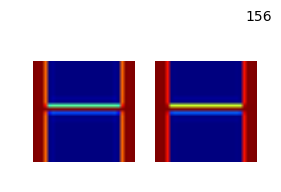

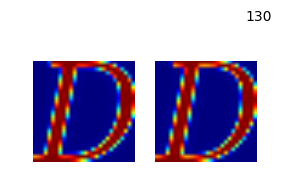

In [119]:
print('number of overlaps: ', len(overlap.keys()))
display_overlap(overlap, test_dataset[:200], train_dataset)

对near duplicate也可以用hash加速， 这可能一开始不容易看出来，因为hash（我们用的md5）不是输入有一点点变动，输出就会变化很大么？原来已经有些技术，比如"locally sensitive hashing", "perceptual hashing" or "difference hashing"。大概看了一下， 很有意思，也不是一两句可以说清楚的。 后面可能专门找时间研究清楚了再写篇blog吧。好在都有python库可以支持的了，需要的自行Google！

下面我们对数据进行清洗，从train_dataset里面去除test_dataset里面的重复数据。由于near duplicate比较复杂， 我只去除了完全duplicate的数据。

In [68]:
def sanitize(dataset1, dataset2, labels1):
    dataset1_hash = np.array([hashlib.md5(img).hexdigest() for img in dataset1])
    dataset2_hash = np.array([hashlib.md5(img).hexdigest() for img in dataset2])
    overlap = []
    for i, hash1 in enumerate(dataset1_hash):
        duplicates = np.where(dataset2_hash == hash1)
        if len(duplicates[0]):
            overlap.append(i)
            
    return np.delete(dataset1, overlap, 0), np.delete(labels1, overlap, None)

In [69]:
%time test_sanitized_dataset, test_labels_sanitized = sanitize(test_dataset[:200], train_dataset, test_labels[:200])
print('num of Sanitize removes images: ', len(test_dataset[:200]) - len(test_sanitized_dataset))

CPU times: user 1.83 s, sys: 22 ms, total: 1.85 s
Wall time: 1.86 s
num of Sanitize removes images:  26


In [85]:
%time test_dataset_sanitized, test_labels_sanitized = sanitize(test_dataset, train_dataset, test_labels)
print('num of Sanitize removes images from test_dataset: ', len(test_dataset) - len(test_sanitized_dataset))

CPU times: user 23.3 s, sys: 1.21 s, total: 24.5 s
Wall time: 25.1 s
num of Sanitize removes images from test_dataset:  1283


In [86]:
%time valid_dataset_sanitized, valid_labels_sanitized = sanitize(valid_dataset, train_dataset, valid_labels)
print('num of Sanitize removes images from valid_dataset: ', len(test_dataset) - len(test_sanitized_dataset))

CPU times: user 23.5 s, sys: 83.9 ms, total: 23.6 s
Wall time: 23.7 s
num of Sanitize removes images from valid_dataset:  1283


In [88]:
pickle_file_sanitized = 'notMNIST_sanitized.pickle'

try:
  f = open(pickle_file_sanitized, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset_sanitized,
    'valid_labels': valid_labels_sanitized,
    'test_dataset': test_dataset_sanitized,
    'test_labels': test_labels_sanitized,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [89]:
statinfo = os.stat(pickle_file_sanitized)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 683484303


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [72]:
logreg = LogisticRegression()
X_test = test_dataset.reshape(test_dataset.shape[0], image_size * image_size)
y_test = test_labels

In [73]:
sample_size = 50
X_train = train_dataset[:sample_size].reshape(sample_size, image_size * image_size)
y_train = train_labels[:sample_size]

%time logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

CPU times: user 39.1 ms, sys: 2.25 ms, total: 41.4 ms
Wall time: 45.6 ms


0.59709999999999996

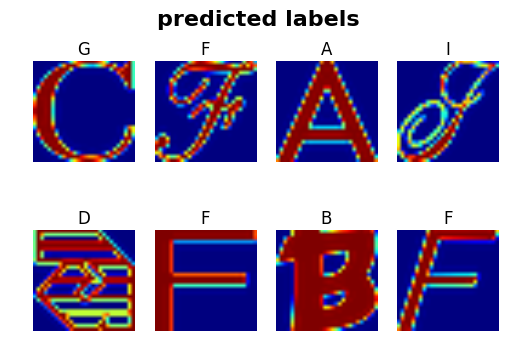

In [74]:
pred_labels = logreg.predict(X_test)
plot_sample_dataset(test_dataset, pred_labels, 'predicted labels')

In [75]:
sample_size = 100
X_train = train_dataset[:sample_size].reshape(sample_size, image_size * image_size)
y_train = train_labels[:sample_size]

%time logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

CPU times: user 100 ms, sys: 1.97 ms, total: 102 ms
Wall time: 102 ms


0.72319999999999995

In [76]:
sample_size = 1000
X_train = train_dataset[:sample_size].reshape(sample_size, image_size * image_size)
y_train = train_labels[:sample_size]

%time logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

CPU times: user 1.87 s, sys: 12.4 ms, total: 1.88 s
Wall time: 1.88 s


0.84350000000000003

In [77]:
sample_size = len(valid_dataset)
X_valid = valid_dataset[:sample_size].reshape(sample_size, image_size * image_size)
y_valid = valid_labels[:sample_size]
logreg.score(X_valid, y_valid)

0.77769999999999995

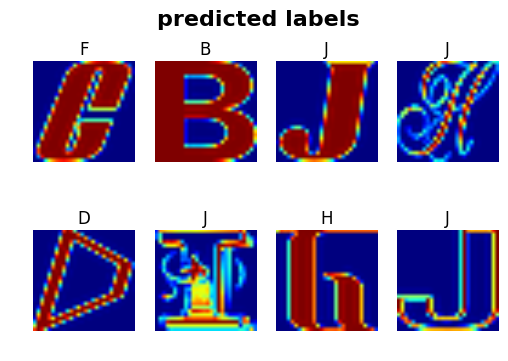

In [78]:
pred_labels = logreg.predict(X_valid)
plot_sample_dataset(valid_dataset, pred_labels, 'predicted labels')

In [79]:
sample_size = 5000
X_train = train_dataset[:sample_size].reshape(sample_size, image_size * image_size)
y_train = train_labels[:sample_size]

%time logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

CPU times: user 18.5 s, sys: 88.5 ms, total: 18.6 s
Wall time: 18.7 s


0.85260000000000002

In [80]:
regr = LogisticRegression(solver='sag')
sample_size = len(train_dataset)
X_train = train_dataset[:sample_size].reshape(sample_size, image_size * image_size)
y_train = train_labels[:sample_size]

%time logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

CPU times: user 27min 31s, sys: 3.72 s, total: 27min 34s
Wall time: 27min 37s


0.89200000000000002

In [81]:
logreg.score(X_valid, y_valid)

0.82809999999999995

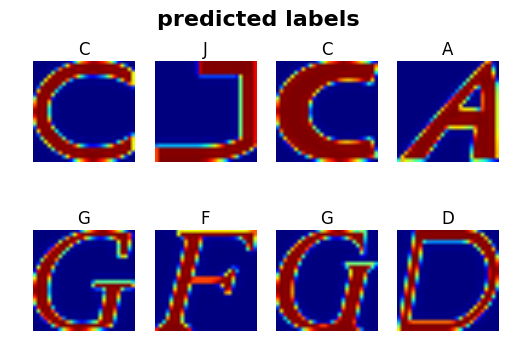

In [82]:
pred_labels = logreg.predict(X_test)
plot_sample_dataset(test_dataset, pred_labels, 'predicted labels')

可以看到在5000的时候能达到83%，而增加到20000似乎没有多大变化85%。 而训练时间增长很快，20000的时候，训练时间已经达到好几分钟， 这算是很慢的了。所以logistic regression不容易scale，急需后面的深度神经网络来优化， 提高精度和速度。